# Execution Quality Analysis

This notebook evaluates execution behavior from `outputs/baseline_mm_result.json`:
- maker/taker mix (inferred from fee sign)
- fee drag
- execution slippage proxy
- adverse-selection proxy (post-fill mid move)

## How to use this notebook

Use this after the baseline run to understand *why* results look the way they do, not just whether headline PnL is positive.

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt

result_path = Path('../outputs/baseline_mm_result.json')
if not result_path.exists():
    raise FileNotFoundError('Missing outputs/baseline_mm_result.json. Run `make report` first.')

with result_path.open('r', encoding='utf-8') as f:
    payload = json.load(f)

summary = payload['summary']
series = payload['series']
fills = payload['fills']
mid = series['mid']

summary

{'final_pnl': 2.0092885364000495,
 'max_drawdown': -5.844895471196594,
 'sharpe_annualized': 5.2167772609053005,
 'fills': 372.0,
 'fees_paid': -1.1533698313992722,
 'avg_abs_inventory': 2.289843773475984}

## 1) Maker/taker mix and fee drag

Fee-sign inference is a proxy for passive vs aggressive execution in this simplified simulator.

In [2]:
maker_count = 0
taker_count = 0
maker_notional = 0.0
taker_notional = 0.0
maker_fee = 0.0
taker_fee = 0.0

for f in fills:
    notional = f['price'] * f['size']
    if f['fee'] <= 0.0:
        maker_count += 1
        maker_notional += notional
        maker_fee += f['fee']
    else:
        taker_count += 1
        taker_notional += notional
        taker_fee += f['fee']

print('maker_count:', maker_count)
print('taker_count:', taker_count)
print('maker_notional:', round(maker_notional, 4))
print('taker_notional:', round(taker_notional, 4))
print('maker_fee (rebate if negative):', round(maker_fee, 6))
print('taker_fee:', round(taker_fee, 6))
print('net_fee:', round(maker_fee + taker_fee, 6))

maker_count: 372
taker_count: 0
maker_notional: 23067.3966
taker_notional: 0.0
maker_fee (rebate if negative): -1.15337
taker_fee: 0.0
net_fee: -1.15337


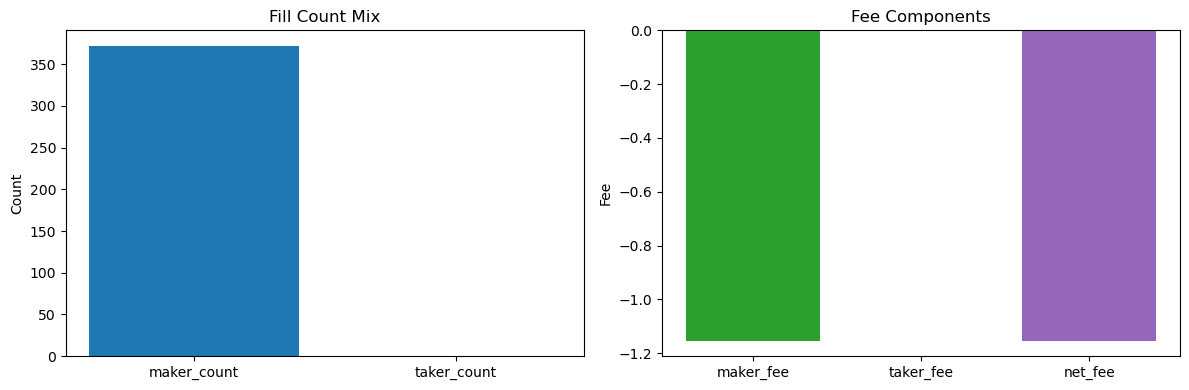

In [3]:
labels = ['maker_count', 'taker_count']
values = [maker_count, taker_count]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(labels, values, color=['tab:blue', 'tab:orange'])
ax[0].set_title('Fill Count Mix')
ax[0].set_ylabel('Count')

fee_labels = ['maker_fee', 'taker_fee', 'net_fee']
fee_values = [maker_fee, taker_fee, maker_fee + taker_fee]
ax[1].bar(fee_labels, fee_values, color=['tab:green', 'tab:red', 'tab:purple'])
ax[1].set_title('Fee Components')
ax[1].set_ylabel('Fee')

plt.tight_layout()
plt.show()

## 2) Slippage proxy analysis

Signed slippage is measured against contemporaneous mid. Positive values imply worse-than-mid execution.

avg_slippage: -0.02912013


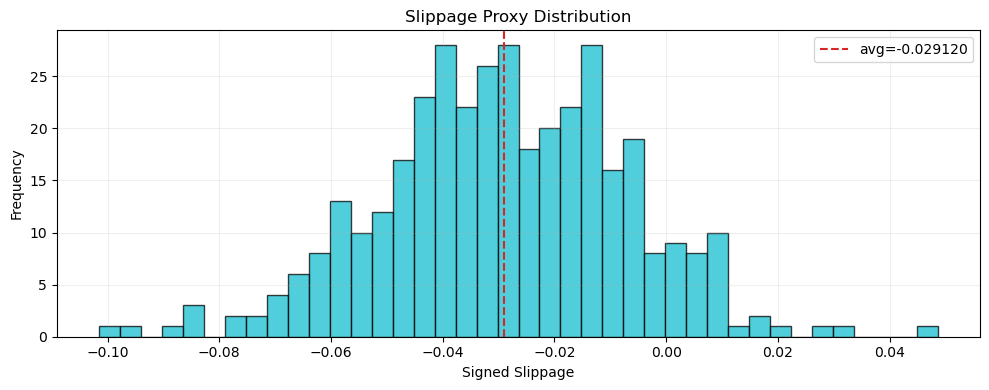

In [4]:
# Slippage proxy relative to contemporaneous mid.
# buy: fill - mid (positive worse), sell: mid - fill (positive worse).
slippage = []
for f in fills:
    step = f['step']
    if not (0 <= step < len(mid)):
        continue
    m = mid[step]
    if f['side'] == 'buy':
        s = f['price'] - m
    else:
        s = m - f['price']
    slippage.append(s)

avg_slippage = sum(slippage) / len(slippage) if slippage else 0.0
print('avg_slippage:', round(avg_slippage, 8))

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(slippage, bins=40, color='tab:cyan', edgecolor='black', alpha=0.75)
ax.axvline(avg_slippage, color='tab:red', linestyle='--', label=f'avg={avg_slippage:.6f}')
ax.set_title('Slippage Proxy Distribution')
ax.set_xlabel('Signed Slippage')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 3) Adverse selection proxy

Post-fill signed mid move estimates toxicity: frequent negative moves after fills can indicate being adversely selected.

avg_post_fill_signed_mid_move: -0.00095816
adverse_selection_rate: 0.5121


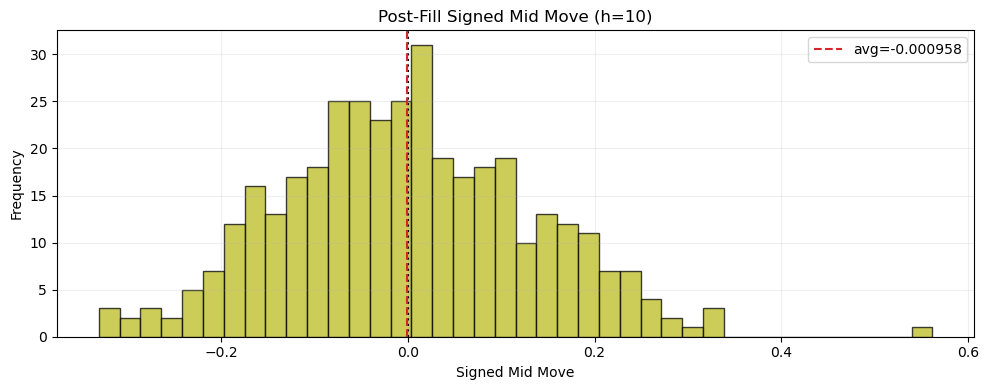

In [5]:
# Adverse-selection proxy: signed mid move after fill over horizon h steps.
# buy fill: mid[t+h] - mid[t] (negative is adverse)
# sell fill: mid[t] - mid[t+h] (negative is adverse)
h = 10
post_move = []
for f in fills:
    t = f['step']
    t2 = t + h
    if not (0 <= t < len(mid) and 0 <= t2 < len(mid)):
        continue
    if f['side'] == 'buy':
        v = mid[t2] - mid[t]
    else:
        v = mid[t] - mid[t2]
    post_move.append(v)

avg_post_move = sum(post_move) / len(post_move) if post_move else 0.0
adverse_rate = sum(1 for x in post_move if x < 0) / len(post_move) if post_move else 0.0
print('avg_post_fill_signed_mid_move:', round(avg_post_move, 8))
print('adverse_selection_rate:', round(adverse_rate, 4))

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(post_move, bins=40, color='tab:olive', edgecolor='black', alpha=0.75)
ax.axvline(0.0, color='black', linestyle=':')
ax.axvline(avg_post_move, color='tab:red', linestyle='--', label=f'avg={avg_post_move:.6f}')
ax.set_title(f'Post-Fill Signed Mid Move (h={h})')
ax.set_xlabel('Signed Mid Move')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## Caveats

- These metrics are model-based diagnostics, not exchange-calibrated TCA.
- Fee-sign maker/taker inference works for this project output format but should be explicit in production logs.